<a href="https://colab.research.google.com/github/kojiyam/machine-learning/blob/main/denso7_regression2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2層ニューラルネットワークによる回帰

文章も含め，ほぼ以下のページのコピーである<br>
PyTroch で実装したニューラルネットワークで回帰問題を解く<br>
回帰問題 (CC BY 4.0)<br>
https://axa.biopapyrus.jp/deep-learning/object-classification/regression-multiple-features.html <br>
2020-07-19 訪問

## サンプルデータ

特徴量 `x1`、特徴量 `x2` および教師ラベル `y` を作成する。

In [ ]:
import numpy as np
np.random.seed(1)

import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 12
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
#plt.style.use('dark_background') # For dark-mode

In [ ]:
x1 = np.random.uniform(low=0, high=2, size=100) # [0, 1]の一様乱数100個
x2 = np.random.uniform(low=0, high=2, size=100) # [0, 1]の一様乱数100個
x = np.stack([x1, x2], axis=1)
y = np.exp(-(x1**2+x2**2)/2.) / np.sqrt(2*np.pi)

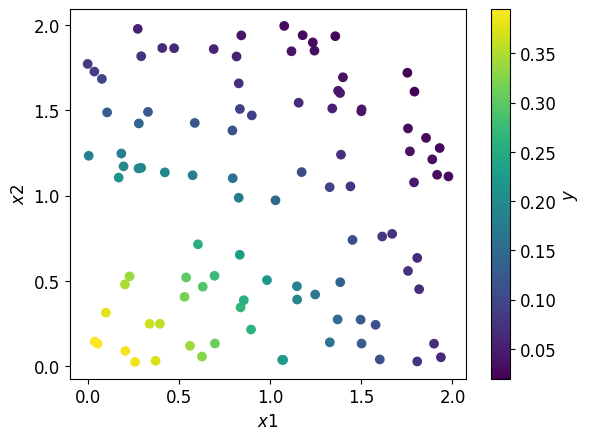

In [ ]:
plt.xlabel("$x1$")
plt.ylabel("$x2$")
plt.xticks(np.arange(0, 2.1, 0.5))
plt.yticks(np.arange(0, 2.1, 0.5))
s = plt.scatter(x1, x2, c=y)
cbar = plt.colorbar(mappable=s)
cbar.set_label('$y$')

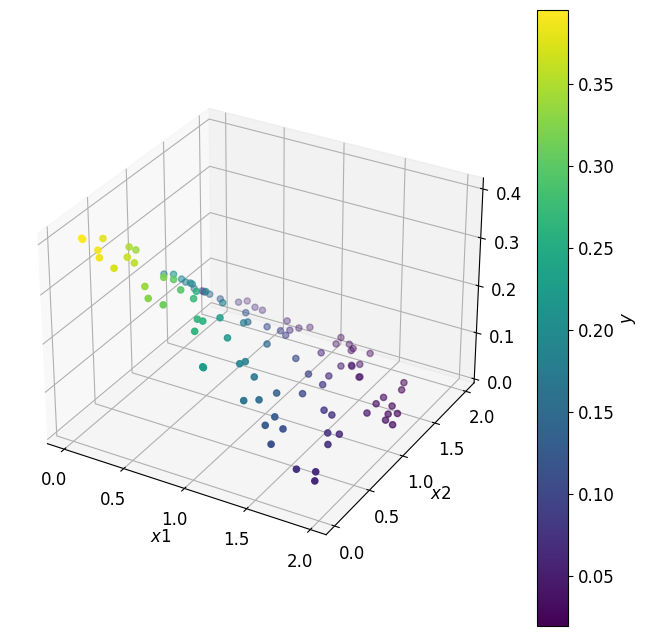

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax= fig.add_subplot(111, projection='3d')
s = ax.scatter(x1, x2, y, c=y)
ax.set_xlabel("$x1$")
ax.set_ylabel("$x2$")
ax.set_xticks(np.arange(0, 2.1, 0.5))
ax.set_yticks(np.arange(0, 2.1, 0.5))
ax.set_zticks(np.arange(0, 0.41, 0.1))
cbar = plt.colorbar(mappable=s)
cbar.set_label('$y$')

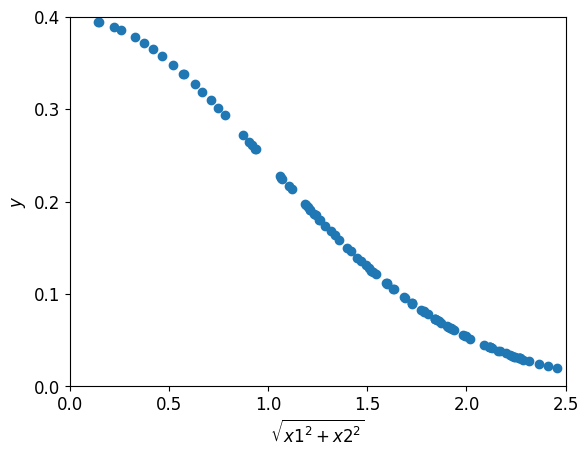

In [ ]:
plt.xlabel("$\sqrt{x1^2+x2^2}$")
plt.ylabel("$y$")
plt.xlim([0, 2.5])
plt.ylim([0, 0.4])
plt.xticks(np.arange(0, 2.51, 0.5))
plt.yticks(np.arange(0, 0.41, 0.1))
plt.scatter(np.sqrt(x1**2+x2**2), y)

## ニューラルネットワークの定義
次に、PyTorch でニューラルネットワークを定義する。ここでは、入力層 (2 unit)、中間層 (64 units)、中間層 (32 units)、および出力層 (1 unit) の 4 層からなるニューラルネットワークを定義している。

（山本追記） <br>
$ \mathbf{c}_1 = \mathbf{W}_1 \mathbf{x} + \mathbf{b}_1$, $\mathbf{x} \in \mathbf{R}^2$, $\mathbf{W}_1 \in \mathbf{R}^{64 \times 2}$, $\mathbf{c}_1, \mathbf{b}_1 \in \mathbf{R}^{64}$ <br>
$ \mathbf{c}_2 = \mathbf{W}_2 \mathrm{ReLU}(\mathbf{c}_1) + \mathbf{b}_2$, $\mathbf{W}_2 \in \mathbf{R}^{32 \times 64}$, $\mathbf{c}_2, \mathbf{b}_2 \in \mathbf{R}^{32}$ <br>
$ y = \mathbf{W}_3 \mathrm{ReLU}(\mathbf{c}_2) + b_3$, $\mathbf{W}_3 \in \mathbf{R}^{1 \times 32}$ <br>
$\mathrm{ReLU}(x)=\max(0,x)$ <br>
なお，隠れ層は2層

In [ ]:
import torch
import torch.nn.functional
import torch.utils.data

class Net(torch.nn.Module):

  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = torch.nn.Linear(2, 64)
    self.fc2 = torch.nn.Linear(64, 32)
    self.fc3 = torch.nn.Linear(32, 1)

  def forward(self, x):
    x = torch.nn.functional.relu(self.fc1(x))
    x = torch.nn.functional.relu(self.fc2(x))
    x = self.fc3(x)
    return x

## 学習
上の定義に基づいてニューラルネットワークを構築し、訓練データを代入して千エポックで学習を進める。学習する際に、勾配効果法 `SGD` を使用して、学習率を 0.01 とする。実際のデータを解析するときは、`Adam` 法を利用したり、サンプル数に応じて学習率をもっと小さい値にしたりする。また、訓練時において、MSE を計算し、これを損失とする。各エポックにおける損失を `epoch_loss` に保存しておく。

In [ ]:
num_epochs = 1000

x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y.reshape(-1, 1)).float()

net = Net()
net.train()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

epoch_loss = []


In [ ]:
for epoch in range(num_epochs):

  outputs = net(x_tensor)
  loss = criterion(outputs, y_tensor)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  epoch_loss.append(loss.data.numpy().tolist())

訓練時における損失 `epoch_loss` を図示して、学習が収束具合を確認する。およそ 600 エポックぐらいで損失がほとんど減らなくなっている。

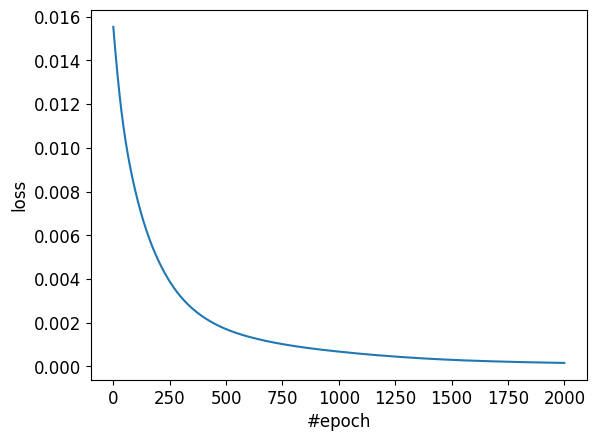

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

## 予測
次に、訓練データの上に、ニューラルネットワークで予測した回帰曲線を描き込む。

In [ ]:
net.eval()

x1g = np.linspace(0, 2, 10)
x2g = np.linspace(0, 2, 10)
x1_test, x2_test = np.meshgrid(x1g, x2g)
x1_test = x1_test.flatten()
x2_test = x2_test.flatten()

x_test = np.stack([x1_test, x2_test], axis=1)

x_test_tensor = torch.from_numpy(x_test).float()

In [ ]:
#x1_test, x2_test

In [ ]:
with torch.no_grad():
  y_pred_tensor = net(x_test_tensor)

y_pred = y_pred_tensor.data.numpy()

回帰曲線を見ると、ここで定義したニューラルネットワークは訓練データをうまくフィッティングできていることを確認できる。ただし、このフィッティングは訓練データに基づくものであり、訓練データの範囲外にあるデータには対応していない。つまり、`_x` がマイナスの時あるいは 10 を超えたときは、予測を大きく外す可能性がある。

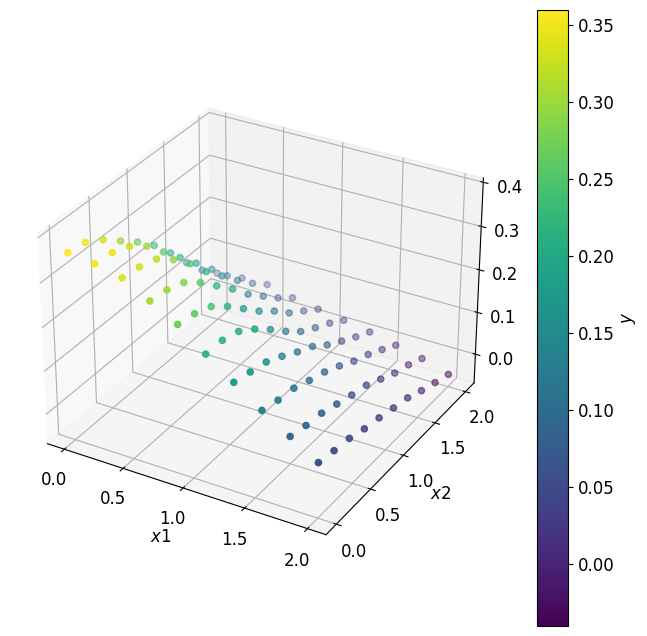

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax= fig.add_subplot(111, projection='3d')
s = ax.scatter(x1_test, x2_test, y_pred, c=y_pred)
ax.set_xlabel("$x1$")
ax.set_ylabel("$x2$")
ax.set_xticks(np.arange(0, 2.1, 0.5))
ax.set_yticks(np.arange(0, 2.1, 0.5))
ax.set_zticks(np.arange(0, 0.41, 0.1))
cbar = plt.colorbar(mappable=s)
cbar.set_label('$y$')

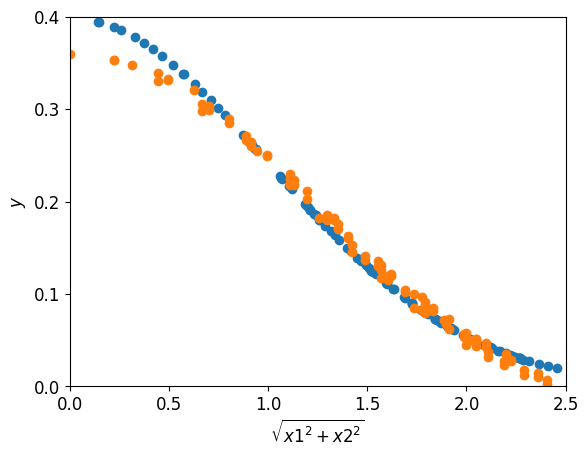

In [ ]:
plt.xlabel("$\sqrt{x1^2+x2^2}$")
plt.ylabel("$y$")
plt.xlim([0, 2.5])
plt.ylim([0, 0.4])
plt.xticks(np.arange(0, 2.51, 0.5))
plt.yticks(np.arange(0, 0.41, 0.1))
plt.scatter(np.sqrt(x1**2+x2**2), y)
plt.scatter(np.sqrt(x1_test**2+x2_test**2), y_pred)

## 山本補足

上記プログラムは要素数2のベクトルであり，2画素の画像と捉えることもできる．<br>
一般の画像を行列と捉えれば，ニューラルネットワークで同じように扱うことができる．<br>
なお，入力を画像とする場合，多くはここで説明した回帰問題ではなく，分類問題である．検索すれば，いくらでも出てくるであろう．